In [97]:
from temds import tile
from osgeo import ogr
import geopandas as gpd
import numpy as np
import rioxarray as rio
from temds import worldclim
from temds import crujra
import xarray as xr

from pathlib import Path

from affine import Affine


In [2]:
c_tile = (7, 16)
tile_index = gpd.read_file('/media/rwspicer/data/V3/tem/00-aoi/tile-index/')
hdx = tile_index['H'] == c_tile[0]
vdx = tile_index['V'] == c_tile[1]
bounds = tile_index[vdx & hdx].bounds
minx, maxx, miny, maxy = bounds[['minx','maxx','miny','maxy']].iloc[0]
minx, maxx, miny, maxy

(-1678000.0, -1402000.0, 2915000.0, 3315000.0)

In [3]:
wc_arctic = worldclim.WorldClim('/media/rwspicer/data/V3/tem/02-arctic/worldclim/worldclim-arctic.nc')

In [4]:
wc_arctic.dataset.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","6931"]]')

In [5]:

annual_list = []
for cru_file in list(Path('/media/rwspicer/data/V3/tem/02-arctic/cru-jra/').glob('*.nc')):
    year = int(cru_file.name.split('.')[-4])
    if year < 1970 or year > 1971:
        continue

    temp = crujra.AnnualDaily(year,cru_file, verbose=False)
    # temp.reproject(tile_index.crs.to_wkt())
    annual_list.append(temp)

annual_list[:5]

[CRUJRAnnualDaily: 1971, CRUJRAnnualDaily: 1970]

In [6]:
cru_arctic_ts = crujra.AnnualTimeSeries(annual_list)

In [7]:
cru_arctic_ts[1970:1975]

AnnualTimeSeries
-CRUJRAnnualDaily: 1970
-CRUJRAnnualDaily: 1971

In [8]:
mytile = tile.Tile(c_tile, bounds, 4000, tile_index.crs.to_wkt(), buffer_px=20)

In [9]:
mytile.import_normalized('worldclim', wc_arctic)

In [10]:
mytile.import_normalized('cru_AnnualTimeSeries', cru_arctic_ts)

CRUJRAnnualDaily: 1970 clipping
CRUJRAnnualDaily: 1971 clipping


In [11]:
mytile.data['cru_AnnualTimeSeries']
mytile.calcualte_cru_longterm_average(1970,1971)

In [12]:
mytile.save('/media/rwspicer/data/V3/tem/03-tiles', overwrite=True)

tmin
tmax
tavg
prec
srad
wind
vapr
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres


In [98]:
self = mytile
wc = self.data['worldclim'].rename({'lat':'y', 'lon':'x'})
wc = wc.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)\
                     .rio.write_crs(tile_index.crs.to_wkt(),inplace=True)\
                     .rio.write_coordinate_system(inplace=True) 
wc = wc.reindex(y=list(reversed(wc.y)))
cruavg = self.data['cru_avg']

cruavg['x'] = wc.x
cruavg['y'] = wc.y

tmax_cf =wc['tmax'] -( cruavg['tmax']- 273.15)

year = 1970
for year in range(1970,1971): #test
    yearly= self.data['cru_AnnualTimeSeries'][year].dataset # CRU
    yearly['x'] = wc.x
    yearly['y'] = wc.y
    yearly['tmax'] - 273.15  

In [126]:
tmax_cf[1]

<xarray.DataArray 'tmax' (y: 140, x: 109)> Size: 61kB
array([[      nan,       nan,       nan, ..., 4.1735573, 4.1735573,
              nan],
       [      nan,       nan,       nan, ..., 4.1729946, 4.173134 ,
              nan],
       [      nan,       nan,       nan, ..., 4.1672544, 4.1685596,
        4.1696568],
       ...,
       [      nan,       nan,       nan, ..., 8.441284 , 8.452209 ,
        8.447717 ],
       [      nan,       nan,       nan, ..., 8.432026 , 8.423738 ,
        8.440718 ],
       [      nan,       nan,       nan, ..., 8.428587 , 8.419891 ,
        8.439746 ]], shape=(140, 109), dtype=float32)
Coordinates:
  * y            (y) float64 1kB 3.393e+06 3.389e+06 ... 2.841e+06 2.837e+06
  * x            (x) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
    time         int64 8B 32
    spatial_ref  int64 8B 0

In [127]:
mn = 0

downscaled = [] 
for mn in range(12): # 0 based
    sel_yr = slice(worldclim.MONTH_START_DAYS[mn]-1,worldclim.DAYS_PER_MONTH[mn])

    downscaled.append((yearly['tmax'] - 273.15)[sel_yr] + tmax_cf[mn])

In [134]:
ds_test = xr.concat(downscaled, dim='time')
ds_test = ds_test.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)\
                     .rio.write_crs(tile_index.crs.to_wkt(),inplace=True)\
                     .rio.write_coordinate_system(inplace=True) 
ds_test.to_netcdf('ds_1970_test.nc', engine='netcdf4')

In [17]:
import matplotlib.pyplot as plt

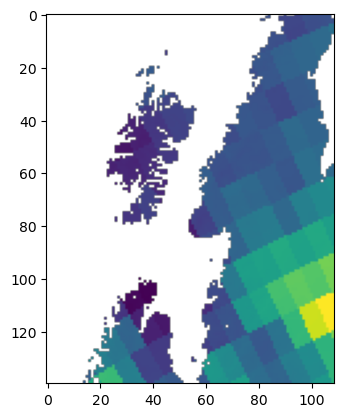

In [118]:
plt.imshow( jan_ds[0])

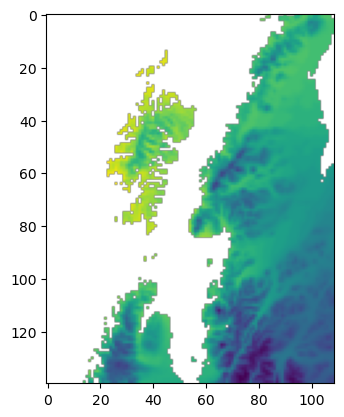

In [66]:
plt.imshow( worldclim['tmax'][1])

In [22]:
t

<xarray.DataArray 'tmax' (time: 12, lat: 140, lon: 109, y: 140, x: 109)> Size: 11GB
array([[[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],

         [[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
...
           -259.911  , -259.911  ],
          [       nan,        nan,        nan, ..., -260.46588,
           -260.46588, -259.911  ],
          [       nan,        nan,        nan, ..., -260.46588,
           -260.46588, -259.911  ]],

         [[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]]]]],
      shape=(12, 140, 109, 140, 109), dtype=float32)
Coordinates:
  * lat          (lat) float64 1kB 2.837e+06 2.841e+06 ... 3.389e+06 3.393e+06
  * lon          (lon) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
  * time         (time) int64 96B 1 32 60 91 121 152 182 213 244 274 305 335
    spatial_ref  int64 8B 0
  * x            (x) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
  * y            (y) float64 1kB 3.395e+06 3.391e+06 ... 2.843e+06 2.839e+06